# LSTM Baseline Model Testing

## 0 Imports & Constants

In [1]:
import sys
import os

# Füge das übergeordnete Verzeichnis zu sys.path hinzu
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, parent_dir)

In [2]:
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy as dc
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from utils.utils import load_time_series, add_lagged_data, scale_data, train_test_split_to_tensor, scale_data_same_scaler
from utils.TimeSeriesDataset import TimeSeriesDataset

from baseline_model.LSTM import LSTM

In [3]:
DATA_FOLDER = Path("../data")
MULTIVARIATE_DATA_FOLDER = DATA_FOLDER / "multivariate"
UNIVARIATE_DATA_FOLDER = DATA_FOLDER / "univariate"
BATCH_SIZE = 16
LEARNING_RATE = 0.001
NUM_EPOCHS = 1000

In [4]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

## 2 Data

### Load Data

In [5]:
# Load data from csv
# -> convert Date column to datetime

df = load_time_series(f'{UNIVARIATE_DATA_FOLDER}/NVDA_open_high_low_close_adjClose_volume_99_24.csv')
df = df[['Close', 'Volume', 'Date']] # remember to put the target column first
df[:10]

,Close,Volume,Date
0,0.041016,2714688000,1999-01-22
1,0.045313,510480000,1999-01-25
2,0.041797,343200000,1999-01-26
3,0.041667,244368000,1999-01-27
4,0.041536,227520000,1999-01-28
5,0.039583,244032000,1999-01-29
6,0.040365,154704000,1999-02-01
7,0.037240,264096000,1999-02-02
8,0.038021,75120000,1999-02-03
9,0.040104,181920000,1999-02-04


### Data Preprocessing

In [6]:
lag = 7
shifted_np_array = add_lagged_data(df, lag, ['Close', 'Volume'])
shifted_np_array.shape

(6384, 8, 2)

In [7]:
scaler = MinMaxScaler(feature_range=(0, 1))
shifted_np_array_same = scale_data(shifted_np_array, scaler)
shifted_np_array

array([[[2.37019144e-05, 2.65347226e-02],
        [4.82342833e-05, 1.46587146e-02],
        [4.36860262e-05, 2.43564991e-02],
        ...,
        [6.27584195e-05, 3.51225511e-02],
        [9.14825281e-05, 5.32830987e-02],
        [5.63780074e-05, 2.92580231e-01]],

       [[2.96254969e-05, 6.01877545e-03],
        [2.41171417e-05, 2.65347226e-02],
        [4.99337351e-05, 1.46587146e-02],
        ...,
        [6.16963790e-05, 2.43929765e-02],
        [6.27584195e-05, 3.51225511e-02],
        [9.14825281e-05, 5.32830987e-02]],

       [[4.54242449e-05, 1.76133862e-02],
        [3.01444977e-05, 6.01877545e-03],
        [2.49668676e-05, 2.65347226e-02],
        ...,
        [6.06261691e-05, 2.25638941e-02],
        [6.16963790e-05, 2.43929765e-02],
        [6.27584195e-05, 3.51225511e-02]],

       ...,

       [[9.49334727e-01, 3.03886279e-02],
        [9.32857901e-01, 2.20244625e-02],
        [9.72756186e-01, 3.19701523e-02],
        ...,
        [1.00000000e+00, 5.52287786e-02],
     

In [8]:
X_train, y_train, X_test, y_test = train_test_split_to_tensor(shifted_np_array)
X_train.shape, y_train.shape, X_test.shape, y_test.shape


(torch.Size([6064, 7, 2]),
 torch.Size([6064, 1]),
 torch.Size([320, 7, 2]),
 torch.Size([320, 1]))

In [9]:
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [10]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [11]:
# Visualize size of batches
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 7, 2]) torch.Size([16, 1])


## 3 Model, Optimizer, Scheduler, Criterion

In [12]:
# parameters for ['Close']: input_size=1, hidden_size=4, num_stacked_layers=1
model = LSTM(
    device=device,
    input_size=2, # number of features per time step
    hidden_size=6,
    num_stacked_layers=1
).to(device)

In [13]:
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, factor=0.7, patience=15, threshold=0.001) #
criterion = nn.MSELoss()

## 4 Train Test Loop

In [14]:
def train_one_epoch(log_interval=100, use_scheduler=False):
    model.train()
    running_train_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        train_pred = model(x_batch)
        train_loss = criterion(train_pred, y_batch)
        running_train_loss += train_loss.item()
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        if batch_index % log_interval == 0:
            
            # log training loss 
            avg_train_loss_across_batches = running_train_loss / log_interval
            print(f'Batch: {batch_index}, Loss: {avg_train_loss_across_batches}')

            # update learning rate
            if(use_scheduler):
                current_learning_rate = scheduler.get_last_lr()
                scheduler.step(avg_train_loss_across_batches)
                if current_learning_rate != scheduler.get_last_lr():
                    print(f'INFO: Scheduler updated Learning rate from ${current_learning_rate} to {scheduler.get_last_lr()}')

            running_train_loss = 0.0 # reset running loss

In [15]:
def validate_one_epoch():
    model.eval()
    running_test_loss = 0.0

    with torch.inference_mode():
        for _, batch in enumerate(test_loader):
            x_batch, y_batch = batch[0].to(device), batch[1].to(device)

            test_pred = model(x_batch)
            test_loss = criterion(test_pred, y_batch)
            running_test_loss += test_loss.item()

    # log validation loss
    avg_test_loss_across_batches = running_test_loss / len(test_loader)
    print(f'Validation Loss: {avg_test_loss_across_batches}')
    return avg_test_loss_across_batches

In [16]:
best_validation_loss = np.inf
patience = 10
num_epoch_without_improvement = 0
for epoch in range(NUM_EPOCHS):
    print(f'Epoch: {epoch + 1}')
    train_one_epoch()
    current_validation_loss = validate_one_epoch()
    
    # early stopping
    if current_validation_loss < best_validation_loss:
        best_validation_loss = current_validation_loss
        num_epoch_without_improvement = 0
    else:
        print(f'INFO: Validation loss did not improve in epoch {epoch + 1}')
        num_epoch_without_improvement += 1

    if num_epoch_without_improvement >= patience:
        print(f'Early stopping after {epoch + 1} epochs')
        break

    print(f'*' * 50)

Epoch: 1
Batch: 0, Loss: 0.000276662465184927
Batch: 100, Loss: 0.005259189653006615
Batch: 200, Loss: 0.0012427941070927773
Batch: 300, Loss: 0.000808803963373066
Validation Loss: 0.0528369992505759
**************************************************
Epoch: 2
Batch: 0, Loss: 1.1899595847353338e-06
Batch: 100, Loss: 0.00018301323238119948
Batch: 200, Loss: 3.3303659192824854e-05
Batch: 300, Loss: 1.3398539693980638e-05
Validation Loss: 0.02040560247187386
**************************************************
Epoch: 3
Batch: 0, Loss: 1.0164083505515009e-07
Batch: 100, Loss: 1.0338983865949559e-05
Batch: 200, Loss: 8.198334882081326e-06
Batch: 300, Loss: 7.728225776872932e-06
Validation Loss: 0.01837785474690463
**************************************************
Epoch: 4
Batch: 0, Loss: 2.640085767779965e-07
Batch: 100, Loss: 8.589676305916782e-06
Batch: 200, Loss: 9.37172299472877e-06
Batch: 300, Loss: 7.52077168527876e-06
Validation Loss: 0.016718727610714267
******************************

### ['Close']
- **hidden: 4, stacked: 1 = 0.017**

### ['Close', 'Volume']
- hidden: 8, stacked: 1 = 0.02
- hidden: 6, stacked: 2 = 0.05
- **hidden: 6, stacked: 1 = 0.008**
    - batch: 8, lr: 0.001 = 0.036
    - batch: 16, lr: 0.001 = 0.008
    - batch: 32, lr: 0.001 = 0.15
    - batch: 16, lr: 0.002 = 0.025
    - batch: 16, lr: 0.0005 = 0.027
- hidden: 4, stacked: 2 = 0.05

## 5 Plot Predictions

### Inverse Transform

In [ ]:
with torch.inference_mode(): 
    test_pred = model(X_test.to(device)).to('cpu').detach().numpy()
    train_pred = model(X_train.to(device)).to('cpu').detach().numpy()

In [ ]:
test_pred = test_pred.flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_pred
dummies = scaler.inverse_transform(dummies)

test_pred = dc(dummies[:, 0])
test_pred

NameError: name 'lookback' is not defined

In [ ]:
train_pred = train_pred.flatten()

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_pred
dummies = scaler.inverse_transform(dummies)

train_pred = dc(dummies[:, 0])
train_pred

array([ 0.0738325 ,  0.07130988,  0.07157708, ..., 23.751987  ,
       23.44890331, 23.16273532])

In [ ]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([ 0.0372388 ,  0.03802074,  0.04010327, ..., 23.55400067,
       23.28800184, 24.18100126])

In [ ]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([ 23.43599945,  22.96500047,  22.96599851,  24.06300004,
        24.22799978,  25.5409996 ,  25.72500151,  25.90000135,
        26.19899855,  26.46799937,  27.19100095,  26.77900062,
        26.53099805,  26.40999877,  26.98400077,  27.38299901,
        27.77699915,  27.9650011 ,  27.45299973,  26.88100167,
        27.03699936,  27.57900103,  27.16900072,  26.49500161,
        26.46299735,  26.75799844,  27.00200096,  27.66700194,
        27.93100074,  27.10399809,  27.1190002 ,  27.04200137,
        26.24099898,  26.95600048,  27.22599935,  27.74900279,
        28.91000104,  28.20999774,  27.80200137,  27.56199889,
        28.67999867,  29.15099764,  28.5709995 ,  28.88499882,
        28.57799761,  28.33999908,  28.95299952,  29.21299828,
        30.17799844,  31.67799824,  31.26400181,  31.1760009 ,
        30.68799979,  30.53799823,  37.98000054,  38.94599874,
        40.11100097,  37.83399903,  39.7699994 ,  39.32700072,
        39.17100107,  38.65399965,  37.47499728,  38.50

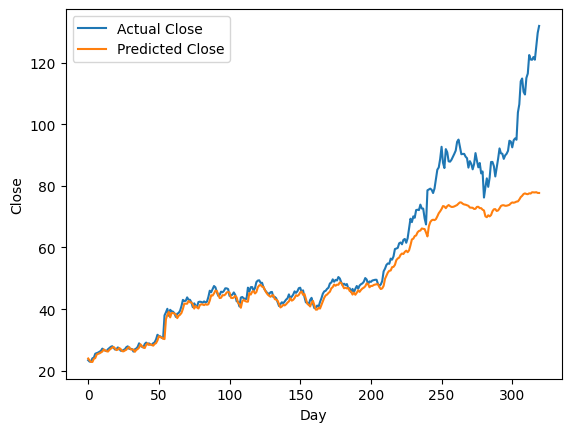

In [ ]:
# plot test data

plt.plot(new_y_test, label="Actual Close")
plt.plot(test_pred, label="Predicted Close")
plt.xlabel("Day")
plt.ylabel("Close")
plt.legend()
plt.show()


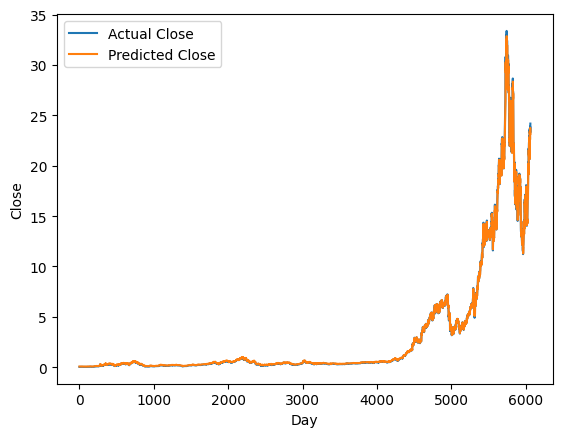

In [ ]:
# plot train data

plt.plot(new_y_train, label="Actual Close")
plt.plot(train_pred, label="Predicted Close")
plt.xlabel("Day")
plt.ylabel("Close")
plt.legend()
plt.show()
